In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import signal

from shapely.geometry import Point

## Emplacement des stations

In [2]:
fleuve = "Garonne"

tableau_stations_file = "../../Data/Extraction_Hydro/" + fleuve + "/Stations.csv"
tableau_stations = pd.read_csv(tableau_stations_file, encoding="UTF-8",
                              delimiter=";")
tableau_stations = gpd.GeoDataFrame(tableau_stations)
n_stations = tableau_stations.shape[0]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [3]:
tableau_stations['geometry'] = tableau_stations.apply(lambda x: Point(float(x['X (m)']), float(x['Y (m)'])), axis = 1)
tableau_stations = tableau_stations.set_crs('EPSG:27572')
tableau_stations = tableau_stations.to_crs(world.crs)
tableau_stations

,Code station,Libelle station,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Regime influencé,Altitude du zéro de l'échelle,Coordonnées,X (m),Y (m),geometry
0,O0010050,La Garonne à Saint-Béat [Aval-HG],False,False,False,False,False,False,True,True,False,False,False,pas ou faiblement,NaN,Lambert II Étendu,465299,1769539,POINT (0.69025 42.91619)
1,O0050010,La Garonne à Chaum,False,False,False,False,False,False,True,True,True,True,True,pas ou faiblement,468.0,Lambert II Étendu,461874,1772141,POINT (0.64772 42.93890)
2,O0200020,La Garonne [partielle] à Saint-Gaudens [Valent...,True,True,True,True,True,True,True,True,True,True,True,pas ou faiblement,357.0,Lambert II Étendu,467072,1789718,POINT (0.70680 43.09775)
3,O0290030,La Garonne à Mancioux,True,True,True,True,True,True,True,True,True,True,True,NaN,NaN,Lambert II Étendu,487648,1796007,POINT (0.95767 43.15778)
4,O0800010,La Garonne à Marquefave,True,True,True,True,True,True,True,True,True,True,True,NaN,NaN,Lambert II Étendu,511286,1813343,POINT (1.24478 43.31687)
5,O1900010,La Garonne à Portet-sur-Garonne,True,True,True,True,True,True,True,True,True,True,True,pas ou faiblement,NaN,Lambert II Étendu,525406,1836493,POINT (1.41519 43.52652)
6,O2620010,La Garonne à Verdun-sur-Garonne,True,True,True,True,True,True,True,True,True,True,True,pas ou faiblement,90.0,Lambert II Étendu,511908,1873173,POINT (1.24218 43.85463)
7,O6140010,La Garonne à Lamagistère,True,True,True,True,True,True,True,True,True,True,True,pas ou faiblement,46.0,Lambert II Étendu,479406,1903351,POINT (0.83130 44.12107)
8,O9000010,La Garonne à Tonneins,True,True,True,True,True,True,True,True,True,True,True,pas ou faiblement,0.0,Lambert II Étendu,431485,1936810,POINT (0.22215 44.41193)


<AxesSubplot:>

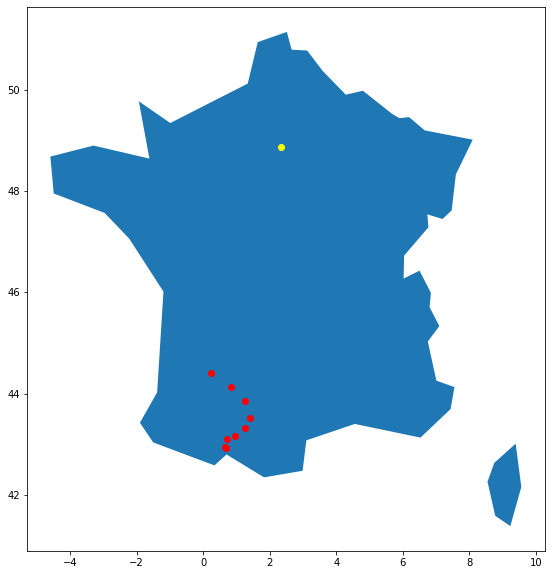

In [4]:
france = world[world['name'] == "France"].geometry.explode().values[[1,2]].unary_union()

base = gpd.GeoSeries(france).plot(figsize = (10, 10))
tableau_stations.plot(ax = base, color = "red")
cities[cities['name'] == "Paris"].plot(ax = base, color = "yellow")

On trie les stations du Sud au Nord.

In [5]:
tableau_stations["Ord"] = tableau_stations["geometry"].apply(lambda x: x.coords[:][0][1])
tableau_stations["Abs"] = tableau_stations["geometry"].apply(lambda x: x.coords[:][0][0])

tri = tableau_stations.sort_values(by = "Ord", ascending=True)[["Code station"]]
for i in range(n_stations):
    code = tri["Code station"][i]
    tableau_stations.loc[tableau_stations["Code station"] == code,"Ordre"] = i

station_amont_pt = tableau_stations["geometry"].to_crs("EPSG:32633")[tableau_stations["Ordre"].values.argmin()]
tableau_stations["Distance amont"] = tableau_stations["geometry"].to_crs("EPSG:32633").distance(station_amont_pt)
tableau_stations

,Code station,Libelle station,2010,2011,2012,2013,2014,2015,2016,2017,...,Regime influencé,Altitude du zéro de l'échelle,Coordonnées,X (m),Y (m),geometry,Ord,Abs,Ordre,Distance amont
0,O0010050,La Garonne à Saint-Béat [Aval-HG],False,False,False,False,False,False,True,True,...,pas ou faiblement,NaN,Lambert II Étendu,465299,1769539,POINT (0.69025 42.91619),42.916185,0.690255,0.0,0.000000
1,O0050010,La Garonne à Chaum,False,False,False,False,False,False,True,True,...,pas ou faiblement,468.0,Lambert II Étendu,461874,1772141,POINT (0.64772 42.93890),42.938900,0.647724,1.0,4363.002463
2,O0200020,La Garonne [partielle] à Saint-Gaudens [Valent...,True,True,True,True,True,True,True,True,...,pas ou faiblement,357.0,Lambert II Étendu,467072,1789718,POINT (0.70680 43.09775),43.097752,0.706803,2.0,20546.926719
3,O0290030,La Garonne à Mancioux,True,True,True,True,True,True,True,True,...,NaN,NaN,Lambert II Étendu,487648,1796007,POINT (0.95767 43.15778),43.157783,0.957667,3.0,35128.209498
4,O0800010,La Garonne à Marquefave,True,True,True,True,True,True,True,True,...,NaN,NaN,Lambert II Étendu,511286,1813343,POINT (1.24478 43.31687),43.316871,1.244780,4.0,64384.855222
5,O1900010,La Garonne à Portet-sur-Garonne,True,True,True,True,True,True,True,True,...,pas ou faiblement,NaN,Lambert II Étendu,525406,1836493,POINT (1.41519 43.52652),43.526519,1.415194,5.0,91202.424087
6,O2620010,La Garonne à Verdun-sur-Garonne,True,True,True,True,True,True,True,True,...,pas ou faiblement,90.0,Lambert II Étendu,511908,1873173,POINT (1.24218 43.85463),43.854633,1.242176,6.0,115212.619523
7,O6140010,La Garonne à Lamagistère,True,True,True,True,True,True,True,True,...,pas ou faiblement,46.0,Lambert II Étendu,479406,1903351,POINT (0.83130 44.12107),44.121072,0.831297,7.0,136493.807654
8,O9000010,La Garonne à Tonneins,True,True,True,True,True,True,True,True,...,pas ou faiblement,0.0,Lambert II Étendu,431485,1936810,POINT (0.22215 44.41193),44.411930,0.222153,8.0,173242.209638


<AxesSubplot:>

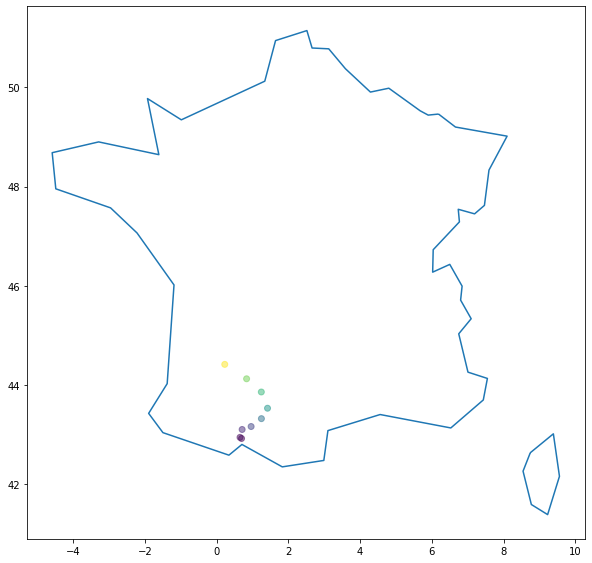

In [6]:
base = gpd.GeoSeries(france).boundary.plot(figsize = (10, 10))
dist_aval = tableau_stations["Distance amont"].values.max()
tableau_stations.plot(ax = base, color = cm.get_cmap("viridis")(tableau_stations["Distance amont"]/dist_aval), alpha = 0.5)

## On rassemble les années

In [7]:
# Initialisation
annees = [a for a in range(2010, 2021)]

for c_annee in annees:
    print(c_annee)
    
    station_dates = tableau_stations["Code station"][tableau_stations[str(c_annee)]].values[0] #Une station avec cette annee présente
    mesures_annee = pd.read_csv("../../Data/Extraction_Hydro/" + fleuve + "/" + station_dates + "_" + str(c_annee) + ".csv",
                                sep = ";")[["Date"]]
    
    for i in range(n_stations):
        code = tableau_stations[tableau_stations["Ordre"] == i]["Code station"].values[0]
        if tableau_stations[tableau_stations["Ordre"] == i][str(c_annee)].values[0]:
            station = pd.read_csv("../../Data/Extraction_Hydro/" + fleuve +"/" + code + "_" + str(c_annee) + ".csv",
                                  sep = ";")
            station = station.rename(columns = {"Q (m3/s)": code})
            mesures_annee = mesures_annee.merge(station[["Date", code]],
                                                on = "Date",
                                                how = "outer")
        else:
            mesures_annee[code] = None
    
    mesures_annee["Date"] = pd.to_datetime(mesures_annee["Date"], format = "%d/%m/%Y %H:%M")
    mesures_annee = mesures_annee.sort_values(by = "Date")
    mesures_annee.to_csv("../../Data/Extraction_Hydro/" + fleuve + "/Mesures_" + str(c_annee) + ".csv",
                        index = False)

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [8]:
mesures = pd.read_csv("../../Data/Extraction_Hydro/" + fleuve + "/Mesures_2010.csv")
mesures["Date"] = pd.to_datetime(mesures["Date"], format = "%Y/%m/%d %H:%M:%S")

for c_annee in annees[1:]:
    print(c_annee)
    mesures_annee = pd.read_csv("../../Data/Extraction_Hydro/" + fleuve + "/Mesures_" + str(c_annee) + ".csv")
    mesures_annee["Date"] = pd.to_datetime(mesures_annee["Date"], format = "%Y/%m/%d %H:%M:%S")
    mesures = pd.concat([mesures, mesures_annee])
mesures = mesures.sort_values(by = "Date")
mesures.to_csv("../../Data/Extraction_Hydro/" + fleuve + "/Mesures.csv",
                        index = False)

2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [9]:
mesures.head()

,Date,O0010050,O0050010,O0200020,O0290030,O0800010,O1900010,O2620010,O6140010,O9000010
0,2010-01-01 00:00:00,NaN,NaN,41.3,50.5,80.4,110.0,122.0,285.0,506.0
1,2010-01-01 02:00:00,NaN,NaN,47.4,33.2,95.7,104.0,125.0,291.0,520.0
2,2010-01-01 04:00:00,NaN,NaN,49.2,52.7,81.2,104.0,132.0,300.0,516.0
3,2010-01-01 06:00:00,NaN,NaN,42.4,40.3,78.2,121.0,135.0,314.0,496.0
4,2010-01-01 08:00:00,NaN,NaN,47.3,50.9,81.0,118.0,132.0,329.0,472.0


## Explorations

In [10]:
mesures = pd.read_csv("../../Data/Extraction_Hydro/" + fleuve + "/Mesures.csv")
mesures["Date"] = pd.to_datetime(mesures["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures.describe(include = "all")

C:\Users\zhouj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,O0010050,O0050010,O0200020,O0290030,O0800010,O1900010,O2620010,O6140010,O9000010
count,48216,6202.000000,17543.000000,48188.000000,48216.000000,48216.000000,48181.000000,48216.000000,48216.000000,48216.000000
unique,48216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,19.554418,32.200314,57.421142,71.594386,109.585698,168.583433,187.510623,353.738628,506.034370
std,NaN,12.949687,23.091163,46.138501,178.483302,110.857203,154.983166,200.699423,330.955854,489.350271
min,NaN,3.620000,8.350000,12.600000,3.550000,11.400000,30.700000,30.400000,42.100000,72.000000
25%,NaN,8.702500,16.900000,26.300000,21.800000,41.100000,66.900000,71.400000,130.000000,177.000000


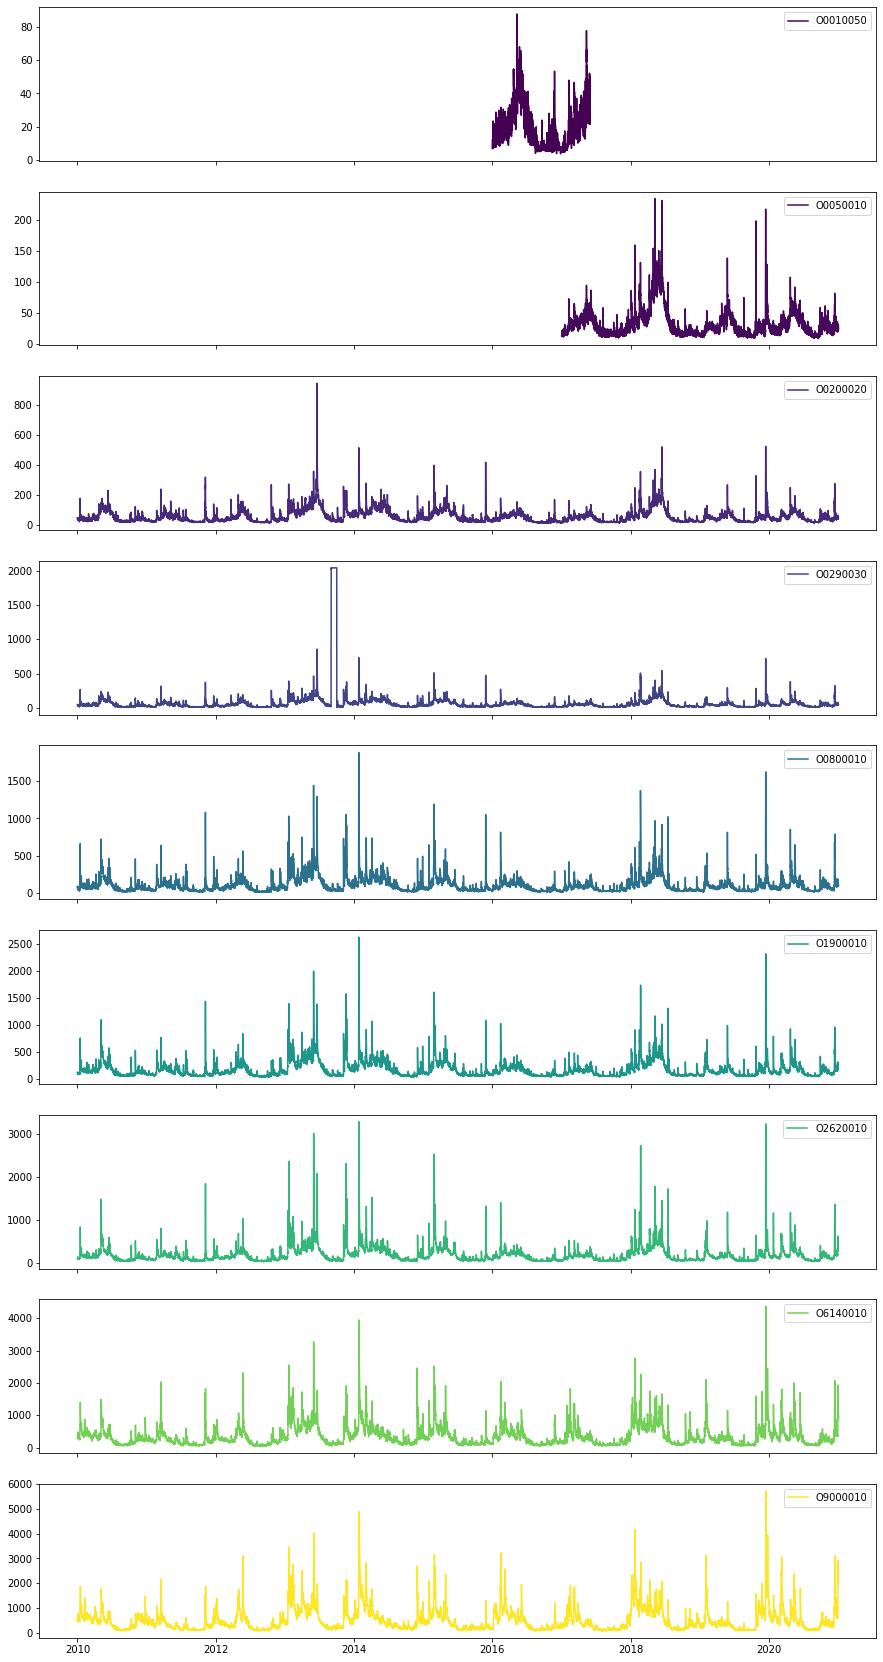

In [11]:
n_stations = tableau_stations.shape[0]
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = tableau_stations[tableau_stations["Ordre"] == i]["Code station"].values[0]
    axs[i].plot(mesures["Date"], mesures[code], label = code, 
                color = cm.get_cmap("viridis")(tableau_stations.loc[i, "Distance amont"]/dist_aval))
    axs[i].legend()

## Nettoyage

In [12]:
mesures.describe(include = "all")

C:\Users\zhouj\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,Date,O0010050,O0050010,O0200020,O0290030,O0800010,O1900010,O2620010,O6140010,O9000010
count,48216,6202.000000,17543.000000,48188.000000,48216.000000,48216.000000,48181.000000,48216.000000,48216.000000,48216.000000
unique,48216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,19.554418,32.200314,57.421142,71.594386,109.585698,168.583433,187.510623,353.738628,506.034370
std,NaN,12.949687,23.091163,46.138501,178.483302,110.857203,154.983166,200.699423,330.955854,489.350271
min,NaN,3.620000,8.350000,12.600000,3.550000,11.400000,30.700000,30.400000,42.100000,72.000000
25%,NaN,8.702500,16.900000,26.300000,21.800000,41.100000,66.900000,71.400000,130.000000,177.000000


A priori, on garde les stations avec les mesures complètes

In [13]:
proportion_mesures = mesures.drop("Date", axis = 1).count()/len(mesures)
proportion_mesures

O0010050    0.128630
O0050010    0.363842
O0200020    0.999419
O0290030    1.000000
O0800010    1.000000
O1900010    0.999274
O2620010    1.000000
O6140010    1.000000
O9000010    1.000000
dtype: float64

In [14]:
stations_complet = []
stations_incomplet = []
for idx, row in proportion_mesures.iteritems():
    if row < 1:
        stations_incomplet.append(idx)
    else:
        stations_complet.append(idx)
stations_incomplet

['O0010050', 'O0050010', 'O0200020', 'O1900010']

In [15]:
proportion_mesures[stations_incomplet]

O0010050    0.128630
O0050010    0.363842
O0200020    0.999419
O1900010    0.999274
dtype: float64

In [16]:
mesures[["Date"] + stations_incomplet]

,Date,O0010050,O0050010,O0200020,O1900010
0,2010-01-01 00:00:00,NaN,NaN,41.3,110.0
1,2010-01-01 02:00:00,NaN,NaN,47.4,104.0
2,2010-01-01 04:00:00,NaN,NaN,49.2,104.0
3,2010-01-01 06:00:00,NaN,NaN,42.4,121.0
4,2010-01-01 08:00:00,NaN,NaN,47.3,118.0
...,...,...,...,...,...
48211,2020-12-31 14:00:00,NaN,30.4,42.3,180.0
48212,2020-12-31 16:00:00,NaN,25.6,45.7,176.0
48213,2020-12-31 18:00:00,NaN,23.0,48.6,182.0
48214,2020-12-31 20:00:00,NaN,23.2,48.9,180.0


In [17]:
mesures[stations_incomplet].isna().sum()

O0010050    42014
O0050010    30673
O0200020       28
O1900010       35
dtype: int64

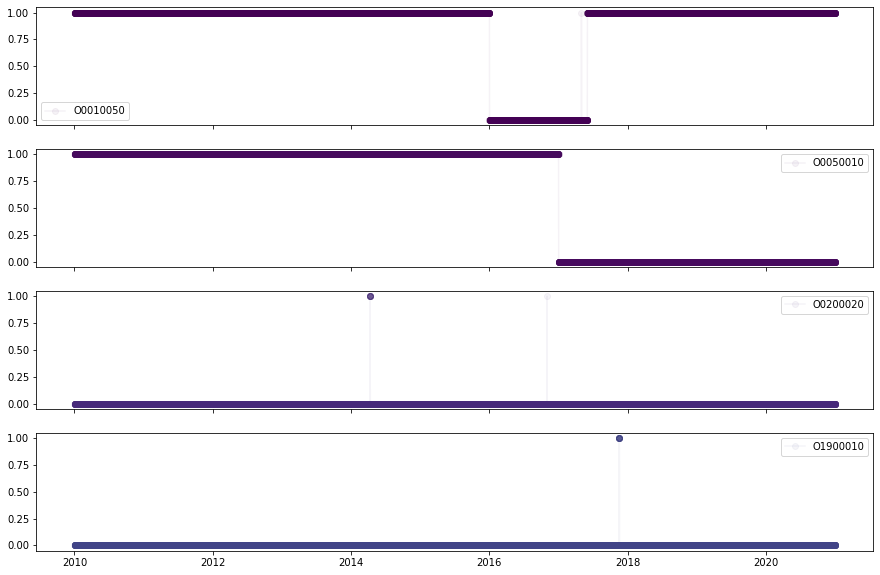

In [18]:
fig, axs = plt.subplots(len(stations_incomplet), 1, figsize = (15,10), sharex=True)
for i in range(len(stations_incomplet)):
    code = stations_incomplet[i]
    axs[i].plot(mesures["Date"], np.isnan(mesures[code]), label = code, 
                color = cm.get_cmap("viridis")(tableau_stations.loc[i, "Distance amont"]/dist_aval), marker = "o", alpha = 0.05)
    axs[i].legend()

On va garder les stations:
- O0200020
- O1900010

In [19]:
stations_interpoler = ["O0200020", "O1900010"]

In [20]:
mesures[["Date"] + stations_interpoler]

,Date,O0200020,O1900010
0,2010-01-01 00:00:00,41.3,110.0
1,2010-01-01 02:00:00,47.4,104.0
2,2010-01-01 04:00:00,49.2,104.0
3,2010-01-01 06:00:00,42.4,121.0
4,2010-01-01 08:00:00,47.3,118.0
...,...,...,...
48211,2020-12-31 14:00:00,42.3,180.0
48212,2020-12-31 16:00:00,45.7,176.0
48213,2020-12-31 18:00:00,48.6,182.0
48214,2020-12-31 20:00:00,48.9,180.0


In [21]:
for code in stations_interpoler:
    mesures[code] = mesures[code].interpolate()

Les stations au total.

In [22]:
stations_garder = stations_complet + stations_interpoler
stations_garder

['O0290030',
 'O0800010',
 'O2620010',
 'O6140010',
 'O9000010',
 'O0200020',
 'O1900010']

In [23]:
tableau_garder = tableau_stations[tableau_stations["Code station"] == stations_garder[0]]
for code in stations_garder[1:]:
    tableau_garder = pd.concat([tableau_garder, tableau_stations[tableau_stations["Code station"] == code]])

# On remet dans l'ordre et garde les colonnes importantes
tableau_garder = tableau_garder.sort_values(by = "Ordre")
tableau_garder["Ordre"] = [i for i in range(tableau_garder.shape[0])]

tableau_garder = tableau_garder[["Code station", "Libelle station", "Regime influencé", "Altitude du zéro de l'échelle", "geometry", "Ordre", ]]
tableau_garder

,Code station,Libelle station,Regime influencé,Altitude du zéro de l'échelle,geometry,Ordre
2,O0200020,La Garonne [partielle] à Saint-Gaudens [Valent...,pas ou faiblement,357.0,POINT (0.70680 43.09775),0
3,O0290030,La Garonne à Mancioux,NaN,NaN,POINT (0.95767 43.15778),1
4,O0800010,La Garonne à Marquefave,NaN,NaN,POINT (1.24478 43.31687),2
5,O1900010,La Garonne à Portet-sur-Garonne,pas ou faiblement,NaN,POINT (1.41519 43.52652),3
6,O2620010,La Garonne à Verdun-sur-Garonne,pas ou faiblement,90.0,POINT (1.24218 43.85463),4
7,O6140010,La Garonne à Lamagistère,pas ou faiblement,46.0,POINT (0.83130 44.12107),5
8,O9000010,La Garonne à Tonneins,pas ou faiblement,0.0,POINT (0.22215 44.41193),6


<AxesSubplot:>

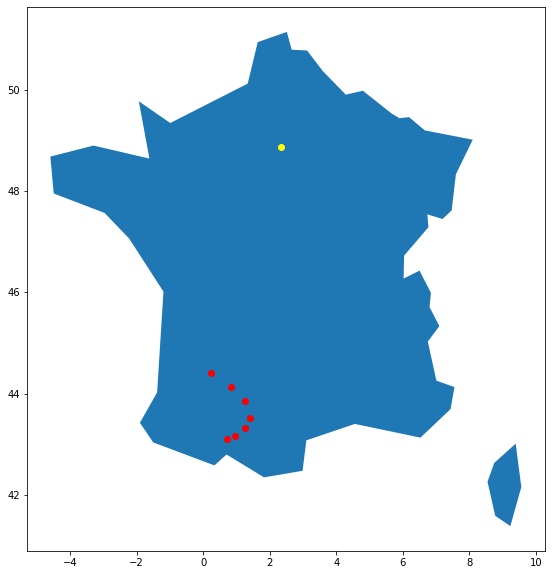

In [24]:
base = gpd.GeoSeries(france).plot(figsize = (10, 10))
tableau_garder.plot(ax = base, color = "red")
cities[cities['name'] == "Paris"].plot(ax = base, color = "yellow")

Mais il manque les altitudes pour 3 stations, on va pas les garder.

<AxesSubplot:>

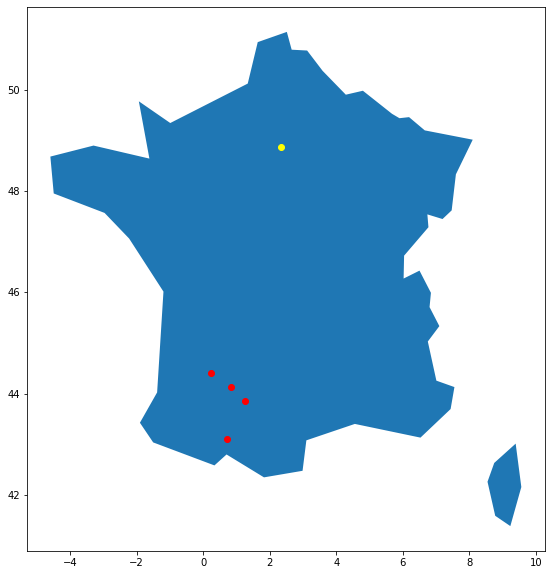

In [25]:
tableau_garder = tableau_garder[np.isnan(tableau_garder["Altitude du zéro de l'échelle"]) == False]
tableau_garder = tableau_garder.sort_values(by = "Ordre")
tableau_garder["Ordre"] = [i for i in range(tableau_garder.shape[0])]

base = gpd.GeoSeries(france).plot(figsize = (10, 10))
tableau_garder[np.isnan(tableau_garder["Altitude du zéro de l'échelle"]) == False].plot(ax = base, color = "red")
cities[cities['name'] == "Paris"].plot(ax = base, color = "yellow")

In [26]:
tableau_garder

,Code station,Libelle station,Regime influencé,Altitude du zéro de l'échelle,geometry,Ordre
2,O0200020,La Garonne [partielle] à Saint-Gaudens [Valent...,pas ou faiblement,357.0,POINT (0.70680 43.09775),0
6,O2620010,La Garonne à Verdun-sur-Garonne,pas ou faiblement,90.0,POINT (1.24218 43.85463),1
7,O6140010,La Garonne à Lamagistère,pas ou faiblement,46.0,POINT (0.83130 44.12107),2
8,O9000010,La Garonne à Tonneins,pas ou faiblement,0.0,POINT (0.22215 44.41193),3


In [27]:
tableau_garder.to_csv("../../Data/Extraction_Hydro/Stations_" + fleuve + ".csv",
                        index = False)

In [28]:
mesures_garder = mesures[["Date"] + list(tableau_garder["Code station"])]
mesures_garder.to_csv("../../Data/Extraction_Hydro/Mesures_" + fleuve + ".csv",
                        index = False)